# Compare Multiple Automated Meta-Analysis Results

This notebook compares **one or more** automated meta-analysis result folders (e.g., different Autonima runs) against each other (self-consistency) and against **manual** NeuroMetaBench meta-analyses.

You can specify a **base folder** plus a **list of result folders**. All automated folders are expected to contain the same outputs structure and comparable result files.


In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pathlib import Path
from nilearn import plotting
import json

## Setup Paths

In [2]:
repos_dir = '/home/zorro/repos'

# Base folder that contains multiple automated meta-analysis runs (subfolders)
# Example:
# base_folder = 'autonima-results/projects/social/coordinates/'
# automated_mas = ['rev3-all_pmids', 'rev3-all_pmids-tableann', 'rev3-other_run']
base_folder = 'autonima-results/projects/social/coordinates/'
automated_mas = [
    'rev3-all_pmids',
    'rev3-all_pmids-tableann',
    'rev3-all_pmids-tableann-ft',
    'rev3-search-all_pmids',
    'rev3-search-all_pmids-tableann',
    'rev3-search-all_pmids-tableann-ft',
]

# Build per-run paths (folder name -> paths)
auto_runs = {
    run_name: {
        "meta_results": os.path.join(base_folder, run_name, 'outputs', 'meta_analysis_results'),
        "annotation_json": os.path.join(base_folder, run_name, 'outputs', 'nimads_annotation.json'),
    }
    for run_name in automated_mas
}

# Manual meta-analysis paths (NeuroMetaBench)
social_meta_path = 'neurometabench/analysis/social'
social_meta_inputs_path = 'neurometabench/data/nimads/social'

# Mapping from NeuroMetaBench social analysis names to autonima-results social analysis names
mappings = {
    "Affiliation-Merged": 'affiliation_attachment',
    "Self-Merged": 'perception_self',
    "Others-Merged": 'perception_others',
    "SocComm-Merged": 'social_communication',
    "ALL-Merged": 'social_processing_all',
}

# Result file to load
result_file = 'z.nii.gz'

# Threshold for Dice coefficient (z-score threshold)
dice_threshold = 1.96


## Load Annotation Data and Count Analyses

In [3]:
def compute_annotation_counts(annotation_path):
    """Load annotation JSON and compute counts per annotation type."""
    with open(os.path.join(repos_dir, annotation_path), 'r') as f:
        meta = json.load(f)

    # Handle list format
    if isinstance(meta, list):
        meta = meta[0]

    notes = meta["notes"]

    # Count analyses per boolean column
    counts = {k: 0 for k in meta["note_keys"].keys()}
    pmids = set()

    for note in notes:
        pmids.add(note.get("pmid", None))
        for k in counts:
            try:
                if bool(note.get(k, False)):
                    counts[k] += 1
            except Exception:
                pass

    pmids = {p for p in pmids if p is not None}
    return counts, pmids, list(counts.keys())

# Load counts for all automated runs
counts_by_run = {}
pmids_by_run = {}
annotation_names_by_run = {}

for run_name, paths in auto_runs.items():
    counts, pmids, annotation_names = compute_annotation_counts(paths["annotation_json"])
    counts_by_run[run_name] = counts
    pmids_by_run[run_name] = pmids
    annotation_names_by_run[run_name] = annotation_names

    print(f"\nRun: {run_name}")
    for k, v in counts.items():
        print(f"  {k}: {v} analyses")
    print(f"  Unique PMIDs: {len(pmids)}")



Run: rev3-all_pmids
  all_analyses: 0 analyses
  all_studies: 0 analyses
  social_processing_all: 0 analyses
  affiliation_attachment: 0 analyses
  social_communication: 0 analyses
  perception_self: 0 analyses
  perception_others: 0 analyses
  Unique PMIDs: 0

Run: rev3-all_pmids-tableann
  all_analyses: 0 analyses
  all_studies: 0 analyses
  social_processing_all: 0 analyses
  affiliation_attachment: 0 analyses
  social_communication: 0 analyses
  perception_self: 0 analyses
  perception_others: 0 analyses
  Unique PMIDs: 0

Run: rev3-all_pmids-tableann-ft
  all_analyses: 0 analyses
  all_studies: 0 analyses
  social_processing_all: 0 analyses
  affiliation_attachment: 0 analyses
  social_communication: 0 analyses
  perception_self: 0 analyses
  perception_others: 0 analyses
  Unique PMIDs: 0

Run: rev3-search-all_pmids
  all_analyses: 0 analyses
  all_studies: 0 analyses
  social_processing_all: 0 analyses
  affiliation_attachment: 0 analyses
  social_communication: 0 analyses
  pe

## Load Manual Meta-Analysis Data

In [4]:
def load_nifti_data(base_dir, subdir, filename):
    """Load a NIfTI file and return the data array."""
    filepath = os.path.join(base_dir, subdir, filename)
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None, None
    
    img = nib.load(filepath)
    data = img.get_fdata()
    return data, filepath

# Load social meta-data inputs
manual_counts = {}
manual_json_dir = os.path.join(repos_dir, social_meta_inputs_path)

for manual_name in mappings.keys():
    json_path = os.path.join(manual_json_dir, f"{manual_name}.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            meta = json.load(f)
        n_studies = len(meta.get("studies", []))
        n_analyses = sum(len(study.get("analyses", [])) for study in meta.get("studies", []))
        manual_counts[manual_name] = {"studies": n_studies, "analyses": n_analyses}
    else:
        print(f"Manual JSON not found: {json_path}")
        manual_counts[manual_name] = {"studies": 0, "analyses": 0}

print("\nManual Meta-Analysis Counts:")
for k, v in manual_counts.items():
    print(f"{k}: {v['studies']} studies, {v['analyses']} analyses")

# Load manual meta-analysis results
manual_data = {}
manual_paths = {}
for manual_name in mappings.keys():
    manual_dir = os.path.join(repos_dir, social_meta_path, manual_name)
    data, filepath = load_nifti_data(repos_dir, os.path.join(social_meta_path, manual_name), result_file)
    if data is not None:
        manual_data[manual_name] = data
        manual_paths[manual_name] = filepath

print(f"\nLoaded {len(manual_data)} manual meta-analysis maps")


Manual Meta-Analysis Counts:
Affiliation-Merged: 34 studies, 106 analyses
Self-Merged: 66 studies, 206 analyses
Others-Merged: 130 studies, 405 analyses
SocComm-Merged: 108 studies, 381 analyses
ALL-Merged: 242 studies, 855 analyses

Loaded 5 manual meta-analysis maps


## Load Automated NIfTI Files

In [5]:
# Load data for each automated run
automated_data = {}
automated_paths = {}

# Determine common annotations across all runs
common_annotations = set.intersection(*[
    set(annotation_names_by_run[run_name])
    for run_name in automated_mas
])

for run_name, paths in auto_runs.items():
    data_run = {}
    paths_run = {}
    for annotation_name in common_annotations:
        data, filepath = load_nifti_data(
            repos_dir,
            os.path.join(paths["meta_results"], annotation_name),
            result_file
        )
        if data is not None:
            data_run[annotation_name] = data
            paths_run[annotation_name] = filepath
    automated_data[run_name] = data_run
    automated_paths[run_name] = paths_run
    print(f"Loaded {len(data_run)} maps for run '{run_name}'")


Loaded 7 maps for run 'rev3-all_pmids'
Loaded 7 maps for run 'rev3-all_pmids-tableann'
Loaded 7 maps for run 'rev3-all_pmids-tableann-ft'
Loaded 7 maps for run 'rev3-search-all_pmids'
Loaded 7 maps for run 'rev3-search-all_pmids-tableann'
Loaded 7 maps for run 'rev3-search-all_pmids-tableann-ft'


## Create Common Mask

In [6]:
def create_common_mask(data_dicts, data_dict_manual=None):
    """Create a mask of voxels that are valid (finite) across all images."""
    masks = []

    for d in data_dicts:
        for _, data in d.items():
            masks.append(np.isfinite(data))

    if data_dict_manual is not None:
        for _, data in data_dict_manual.items():
            masks.append(np.isfinite(data))

    if len(masks) == 0:
        return None

    # Combine all masks
    common_mask = masks[0]
    for mask in masks[1:]:
        common_mask = common_mask & mask

    print(f"Common mask: {np.sum(common_mask)} valid voxels")
    return common_mask

# Create common mask (including manual data)
common_mask = create_common_mask(list(automated_data.values()), manual_data)

# Apply mask to all data
automated_data_masked = {
    run_name: {name: data.flatten()[common_mask.flatten()] for name, data in data_run.items()}
    for run_name, data_run in automated_data.items()
}
manual_data_masked = {name: data.flatten()[common_mask.flatten()] for name, data in manual_data.items()}


Common mask: 902629 valid voxels


## Compute Dice Coefficients

In [7]:
def compute_dice_coefficient(img1, img2, threshold=0):
    """Compute Dice coefficient between two binary masks."""
    binary1 = img1 > threshold
    binary2 = img2 > threshold

    intersection = np.sum(binary1 & binary2)
    sum_volumes = np.sum(binary1) + np.sum(binary2)

    if sum_volumes == 0:
        return 0.0

    dice = (2.0 * intersection) / sum_volumes
    return dice

def compute_dice_matrix(data_dict_1, data_dict_2, threshold=0):
    """Compute Dice coefficient matrix between two sets of data."""
    names_1 = list(data_dict_1.keys())
    names_2 = list(data_dict_2.keys())

    dice_matrix = np.zeros((len(names_1), len(names_2)))
    for i, name_1 in enumerate(names_1):
        for j, name_2 in enumerate(names_2):
            vec_1 = data_dict_1[name_1]
            vec_2 = data_dict_2[name_2]
            dice = compute_dice_coefficient(vec_1, vec_2, threshold)
            dice_matrix[i, j] = dice

    return dice_matrix, names_1, names_2

# Compute Dice matrices for each run (self-comparison)
dice_self = {}
names_self = {}

for run_name, data_run in automated_data_masked.items():
    dice_mat, row_names, col_names = compute_dice_matrix(data_run, data_run, dice_threshold)
    dice_self[run_name] = dice_mat
    names_self[run_name] = (row_names, col_names)

print("\nDice matrix shapes (self-comparison):")
for run_name, mat in dice_self.items():
    print(f"  {run_name}: {mat.shape}")



Dice matrix shapes (self-comparison):
  rev3-all_pmids: (7, 7)
  rev3-all_pmids-tableann: (7, 7)
  rev3-all_pmids-tableann-ft: (7, 7)
  rev3-search-all_pmids: (7, 7)
  rev3-search-all_pmids-tableann: (7, 7)
  rev3-search-all_pmids-tableann-ft: (7, 7)


## Visualize Dice Coefficient Matrices (Self-Comparison, All Runs)

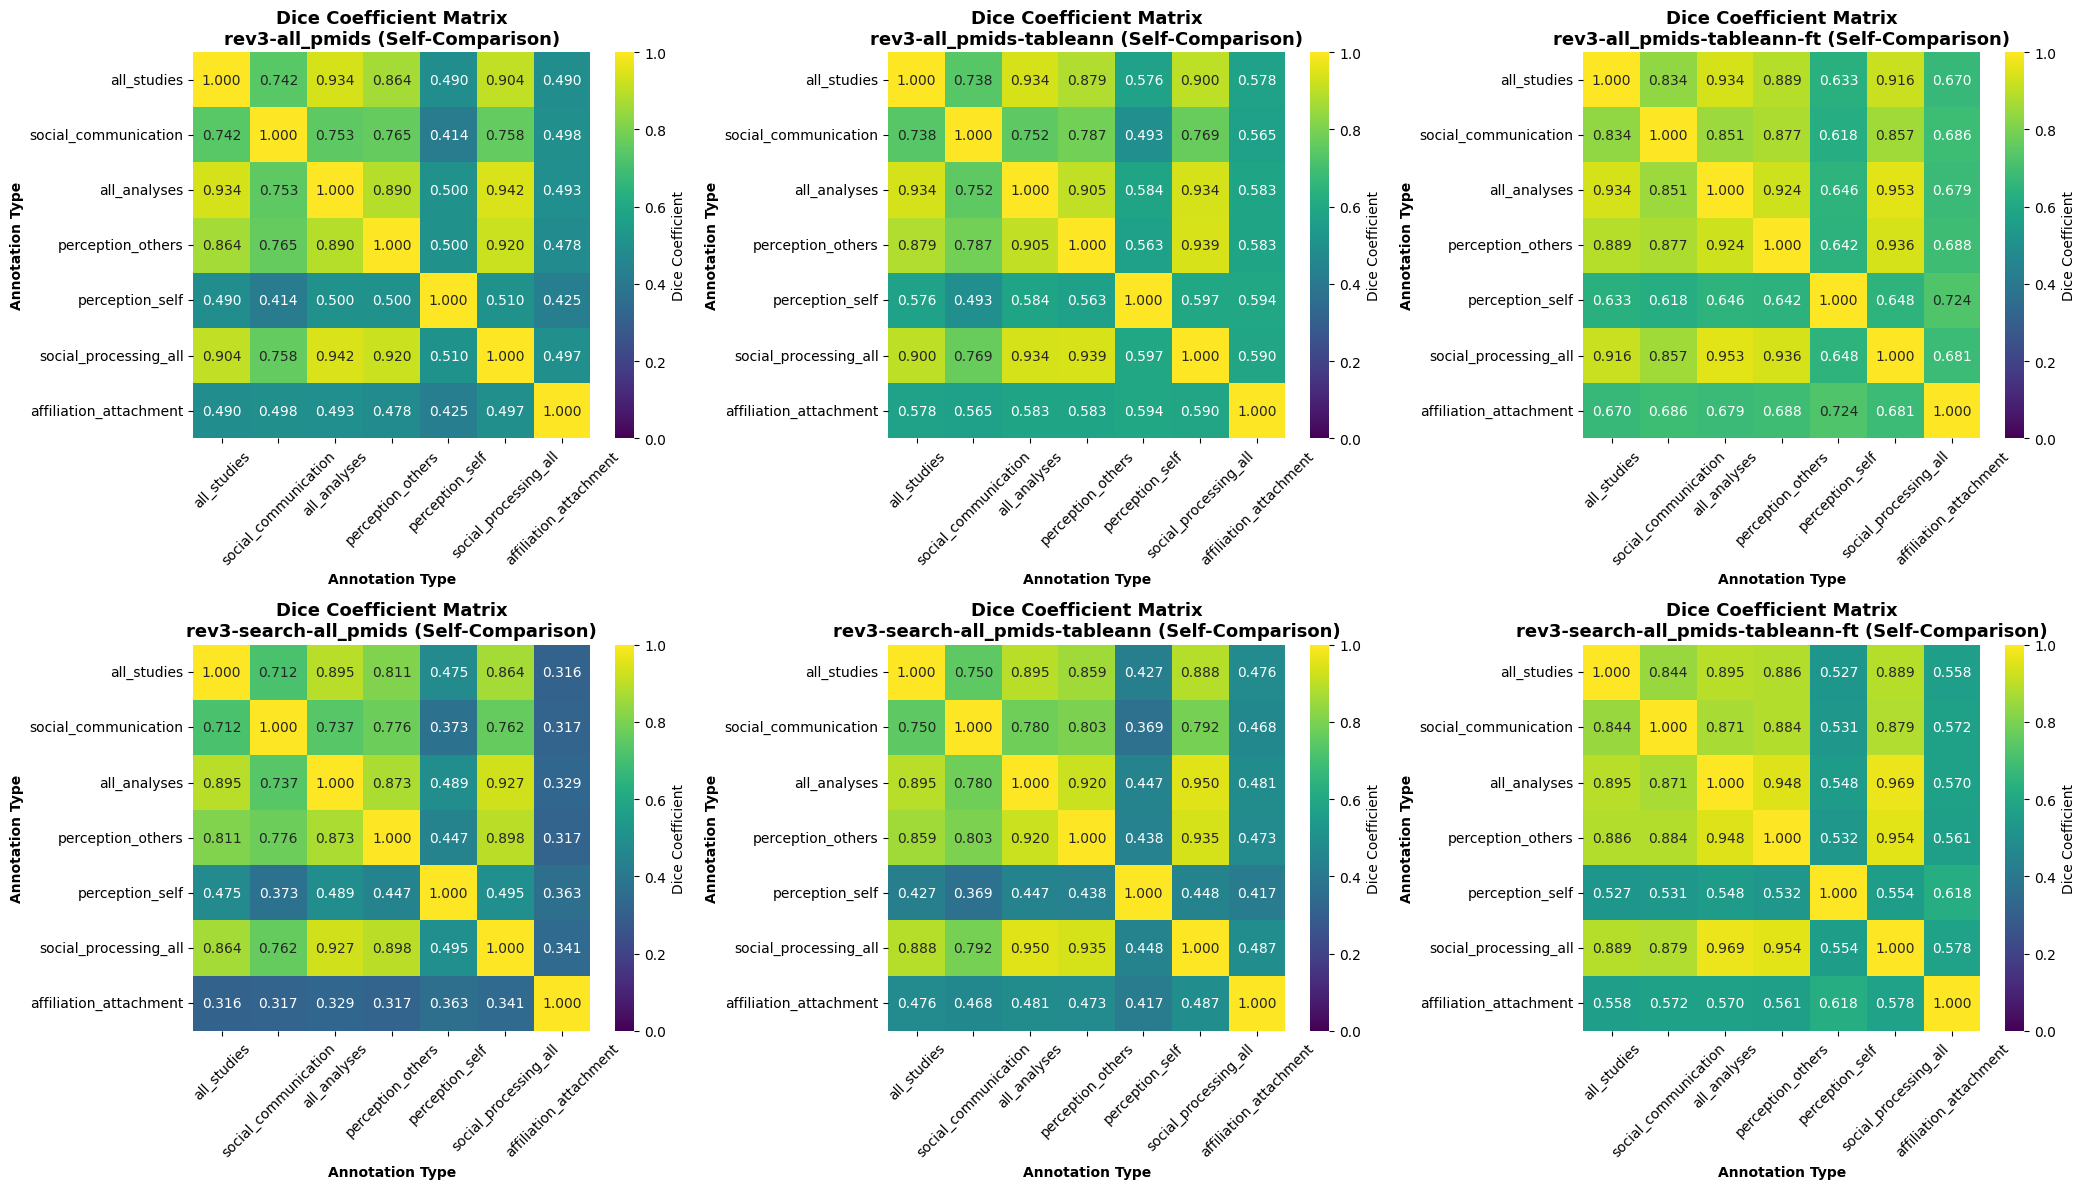

In [8]:
# Visualize self-comparison Dice matrices for all automated runs
n_runs = len(dice_self)
if n_runs == 0:
    raise ValueError("No automated runs loaded. Check base_folder/automated_mas and file paths.")

cols = min(3, n_runs)
rows = int(np.ceil(n_runs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows))
axes = np.atleast_1d(axes).flatten()

for ax in axes[n_runs:]:
    ax.axis('off')

for i, (run_name, dice_mat) in enumerate(dice_self.items()):
    row_names, col_names = names_self[run_name]
    sns.heatmap(
        dice_mat, annot=True, fmt='.3f', cmap='viridis',
        xticklabels=col_names, yticklabels=row_names,
        vmin=0, vmax=1, ax=axes[i], cbar_kws={'label': 'Dice Coefficient'}
    )
    axes[i].set_title(f'Dice Coefficient Matrix\n{run_name} (Self-Comparison)', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Annotation Type', fontweight='bold')
    axes[i].set_ylabel('Annotation Type', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('dice_coefficient_matrix_self_all_runs.png', dpi=300, bbox_inches='tight')
plt.show()


## Summary Statistics

In [9]:
# Summary statistics for each self-comparison Dice matrix
summary_rows = []
for run_name, mat in dice_self.items():
    # Exclude diagonal for off-diagonal summary
    diag = np.diagonal(mat)
    off = mat[~np.eye(mat.shape[0], dtype=bool)] if mat.size else np.array([])
    summary_rows.append({
        "run": run_name,
        "n_maps": mat.shape[0],
        "mean_diagonal": float(np.mean(diag)) if diag.size else np.nan,
        "mean_offdiag": float(np.mean(off)) if off.size else np.nan,
        "min": float(np.min(mat)) if mat.size else np.nan,
        "max": float(np.max(mat)) if mat.size else np.nan,
    })

summary_df = pd.DataFrame(summary_rows).set_index("run")
display(summary_df)


,n_maps,mean_diagonal,mean_offdiag,min,max
run,,,,,
rev3-all_pmids,7,1.0,0.655692,0.414030,1.0
rev3-all_pmids-tableann,7,1.0,0.706685,0.492539,1.0
rev3-all_pmids-tableann-ft,7,1.0,0.775553,0.618148,1.0
rev3-search-all_pmids,7,1.0,0.595990,0.315685,1.0
rev3-search-all_pmids-tableann,7,1.0,0.642963,0.369143,1.0
rev3-search-all_pmids-tableann-ft,7,1.0,0.722332,0.526959,1.0


## Compare Automated Analyses to Manual Meta-Analyses

In [10]:
# Align automated runs to the manual meta-analyses using `mappings`
# We'll build one aligned manual dict keyed by the *automated* annotation names (values from `mappings`),
# and one aligned automated dict per run with the same keys.

manual_aligned = {}
for manual_name, auto_name in mappings.items():
    if manual_name in manual_data_masked:
        manual_aligned[auto_name] = manual_data_masked[manual_name]

aligned_auto_by_run = {}
for run_name, data_run in automated_data_masked.items():
    aligned = {}
    for manual_name, auto_name in mappings.items():
        if auto_name in data_run:
            aligned[auto_name] = data_run[auto_name]
    aligned_auto_by_run[run_name] = aligned

print("Aligned maps:")
print(f"  Manual: {len(manual_aligned)} maps")
for run_name, aligned in aligned_auto_by_run.items():
    print(f"  {run_name}: {len(aligned)} maps")

# Compute Dice matrices (automated vs manual) for each run
dice_auto_vs_manual = {}
names_auto_vs_manual = {}

for run_name, aligned_auto in aligned_auto_by_run.items():
    dice_mat, row_names, col_names = compute_dice_matrix(aligned_auto, manual_aligned, dice_threshold)
    dice_auto_vs_manual[run_name] = dice_mat
    names_auto_vs_manual[run_name] = (row_names, col_names)

print("\nDice matrix shapes (auto vs manual):")
for run_name, mat in dice_auto_vs_manual.items():
    print(f"  {run_name}: {mat.shape}")


Aligned maps:
  Manual: 5 maps
  rev3-all_pmids: 5 maps
  rev3-all_pmids-tableann: 5 maps
  rev3-all_pmids-tableann-ft: 5 maps
  rev3-search-all_pmids: 5 maps
  rev3-search-all_pmids-tableann: 5 maps
  rev3-search-all_pmids-tableann-ft: 5 maps



Dice matrix shapes (auto vs manual):
  rev3-all_pmids: (5, 5)
  rev3-all_pmids-tableann: (5, 5)
  rev3-all_pmids-tableann-ft: (5, 5)
  rev3-search-all_pmids: (5, 5)
  rev3-search-all_pmids-tableann: (5, 5)
  rev3-search-all_pmids-tableann-ft: (5, 5)


## Visualize Automated vs Manual Dice Matrices

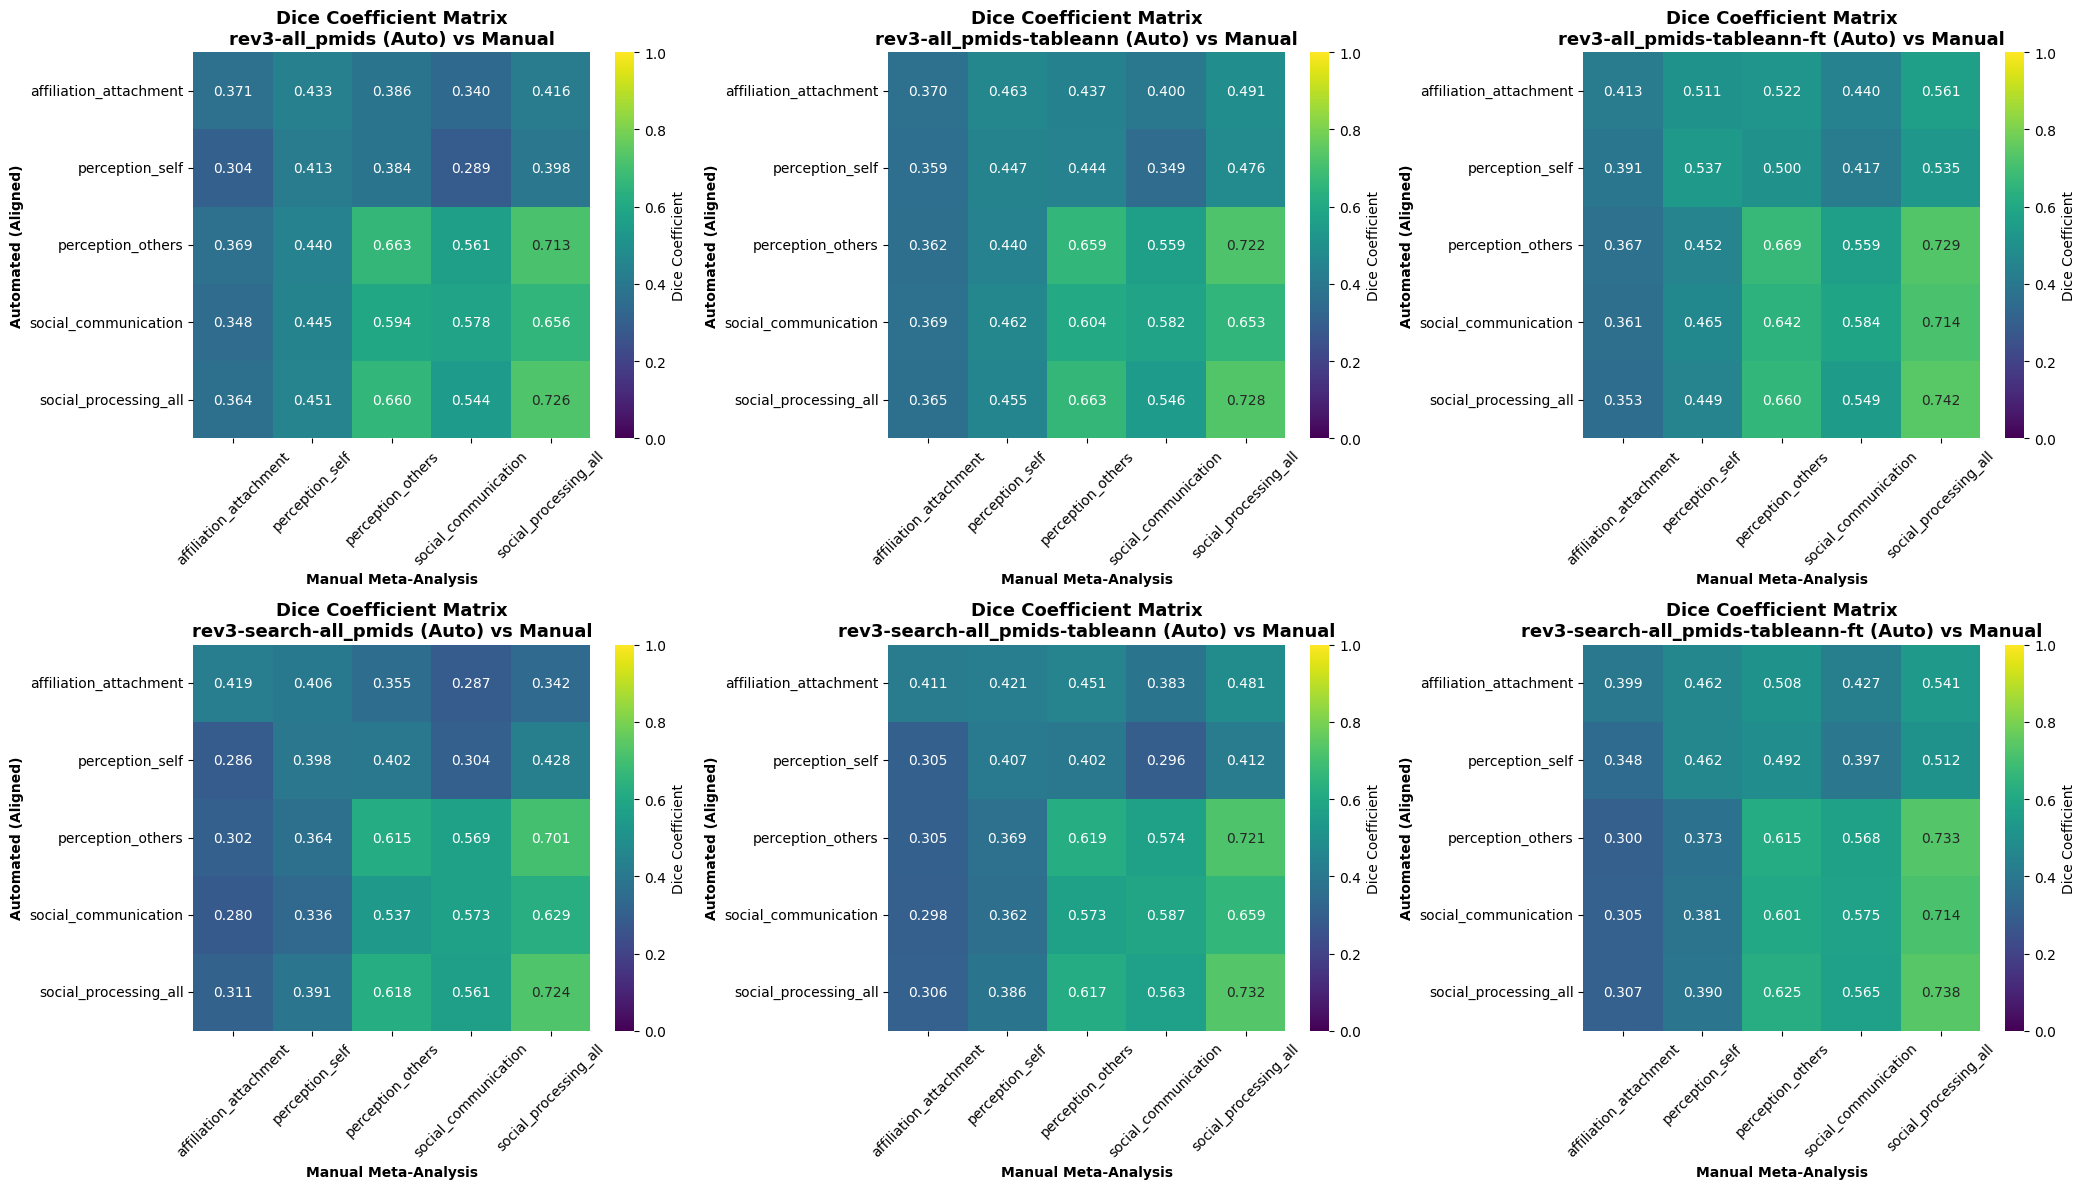

In [11]:
# Visualize Auto vs Manual Dice matrices for all runs
n_runs = len(dice_auto_vs_manual)
cols = min(3, n_runs) if n_runs else 1
rows = int(np.ceil(n_runs / cols)) if n_runs else 1

fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 6*rows))
axes = np.atleast_1d(axes).flatten()

for ax in axes[n_runs:]:
    ax.axis('off')

for i, (run_name, dice_mat) in enumerate(dice_auto_vs_manual.items()):
    row_names, col_names = names_auto_vs_manual[run_name]
    sns.heatmap(
        dice_mat, annot=True, fmt='.3f', cmap='viridis',
        xticklabels=col_names, yticklabels=row_names,
        vmin=0, vmax=1, ax=axes[i], cbar_kws={'label': 'Dice Coefficient'}
    )
    axes[i].set_title(f'Dice Coefficient Matrix\n{run_name} (Auto) vs Manual', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Manual Meta-Analysis', fontweight='bold')
    axes[i].set_ylabel('Automated (Aligned)', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('dice_coefficient_automated_vs_manual_all_runs.png', dpi=300, bbox_inches='tight')
plt.show()


## Diagonal Dice: Matching Automated vs Manual

,rev3-all_pmids,rev3-all_pmids-tableann,rev3-all_pmids-tableann-ft,rev3-search-all_pmids,rev3-search-all_pmids-tableann,rev3-search-all_pmids-tableann-ft
affiliation_attachment,0.370508,0.369749,0.412958,0.419119,0.411260,0.398614
perception_self,0.412642,0.447020,0.536528,0.398145,0.406660,0.461950
perception_others,0.663500,0.659366,0.669489,0.615473,0.618988,0.614758
social_communication,0.578411,0.581699,0.584028,0.572971,0.587454,0.575015
social_processing_all,0.726048,0.728052,0.741710,0.723988,0.731859,0.737610


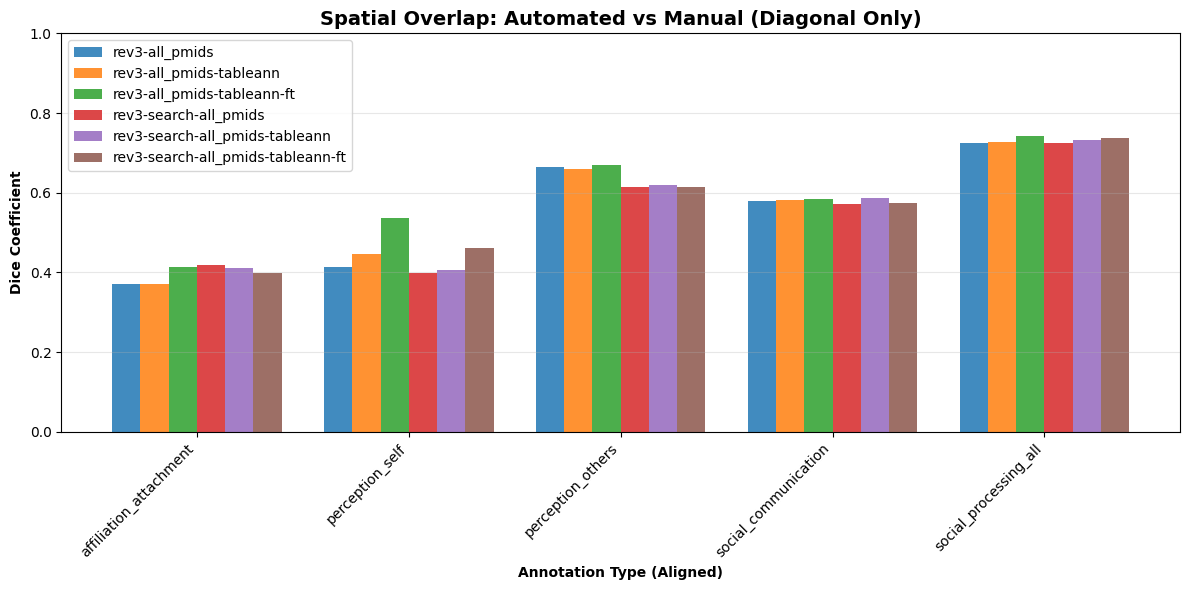

In [12]:
# Extract diagonal Dice (matching auto_name == manual mapped)
# For each run, we will compute dice(auto_name, manual auto_name) in a consistent order.

diag_order = [auto_name for _, auto_name in mappings.items() if auto_name in manual_aligned]
diag_table = pd.DataFrame(index=diag_order)

for run_name, aligned_auto in aligned_auto_by_run.items():
    vals = []
    for auto_name in diag_order:
        if auto_name in aligned_auto and auto_name in manual_aligned:
            vals.append(compute_dice_coefficient(aligned_auto[auto_name], manual_aligned[auto_name], dice_threshold))
        else:
            vals.append(np.nan)
    diag_table[run_name] = vals

display(diag_table)

# Grouped bar plot (one bar per run per annotation)
n_runs = diag_table.shape[1]
x = np.arange(len(diag_table.index))
width = 0.8 / max(1, n_runs)

fig, ax = plt.subplots(figsize=(max(12, 0.9*len(x)), 6))
for i, run_name in enumerate(diag_table.columns):
    ax.bar(x - 0.4 + (i + 0.5) * width, diag_table[run_name].values, width, label=run_name, alpha=0.85)

ax.set_ylabel('Dice Coefficient', fontweight='bold')
ax.set_xlabel('Annotation Type (Aligned)', fontweight='bold')
ax.set_title('Spatial Overlap: Automated vs Manual (Diagonal Only)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(diag_table.index, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('dice_diagonal_auto_vs_manual_all_runs.png', dpi=300, bbox_inches='tight')
plt.show()



Full Dice Matrices (Auto vs Manual):

Run: rev3-all_pmids


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


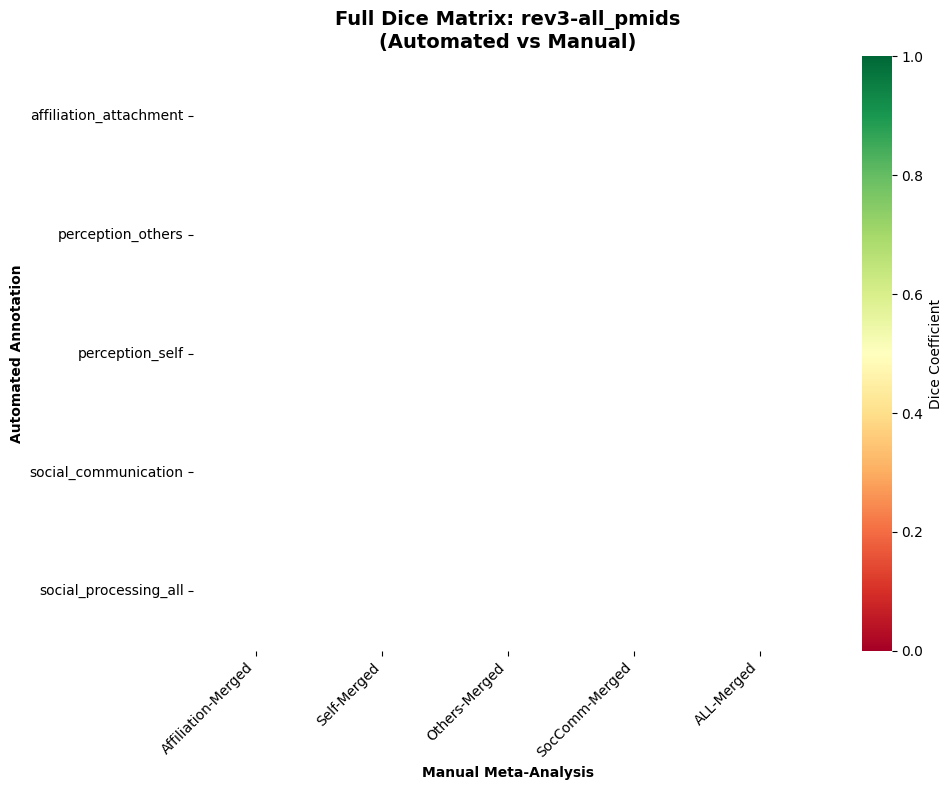


Statistics for rev3-all_pmids:

Run: rev3-all_pmids-tableann


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


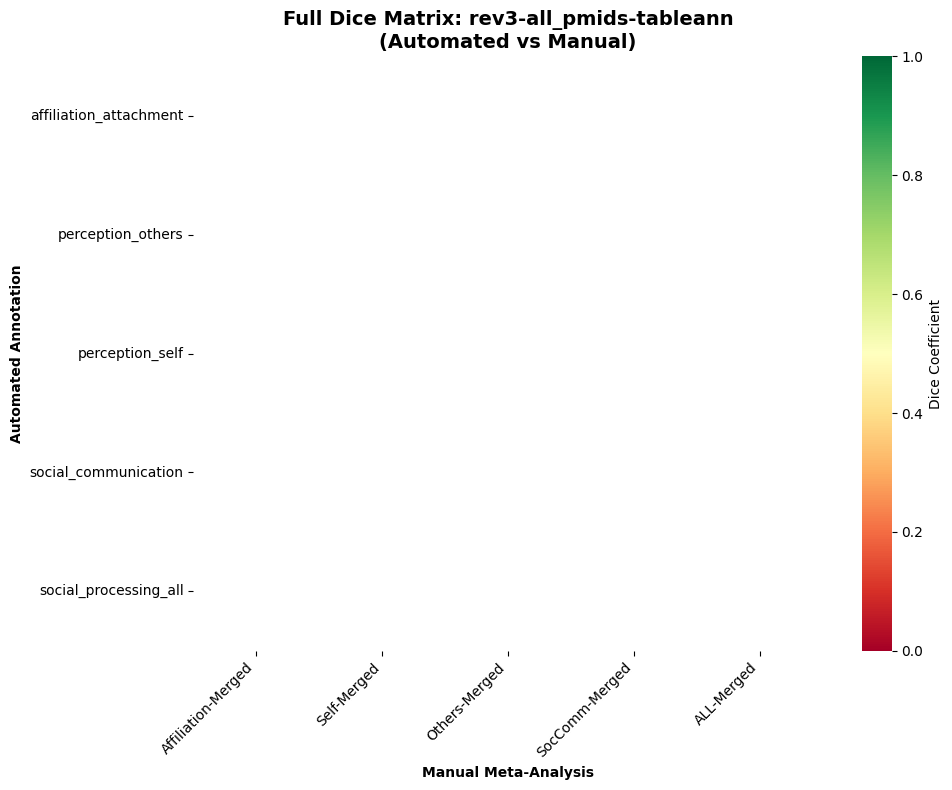


Statistics for rev3-all_pmids-tableann:

Run: rev3-all_pmids-tableann-ft


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


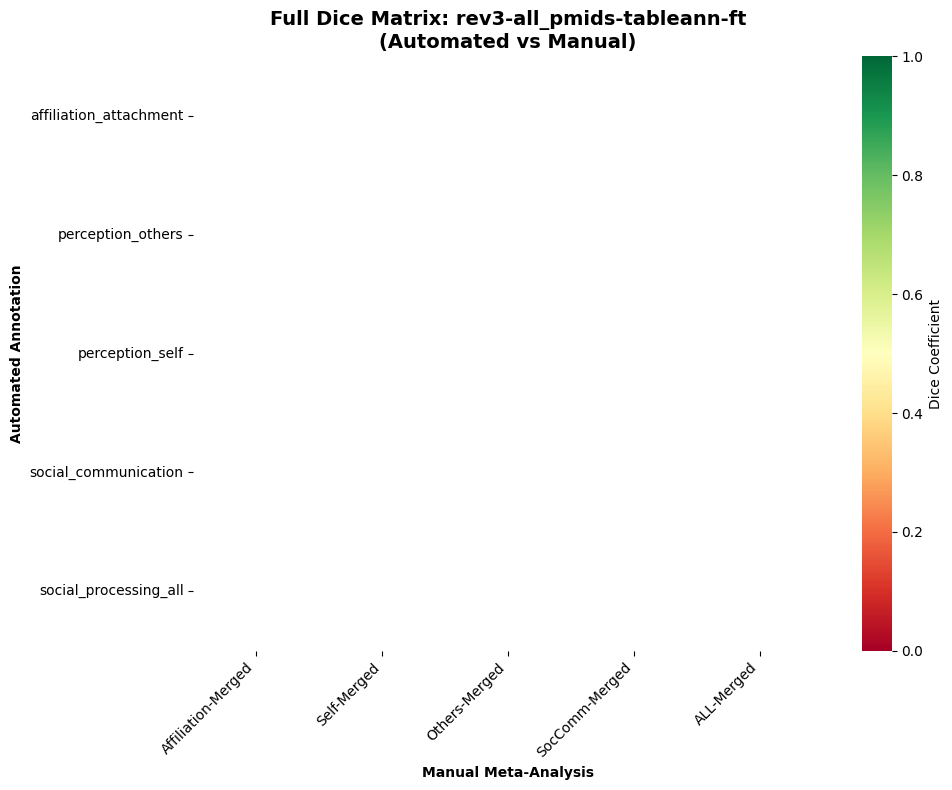


Statistics for rev3-all_pmids-tableann-ft:

Run: rev3-search-all_pmids


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


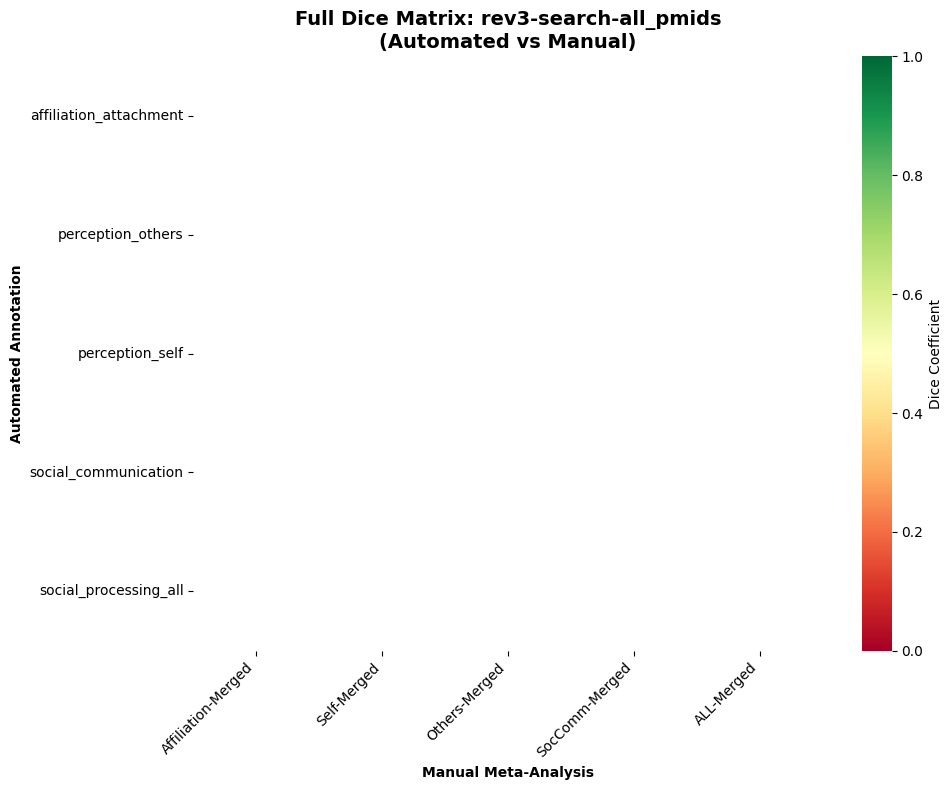


Statistics for rev3-search-all_pmids:

Run: rev3-search-all_pmids-tableann


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


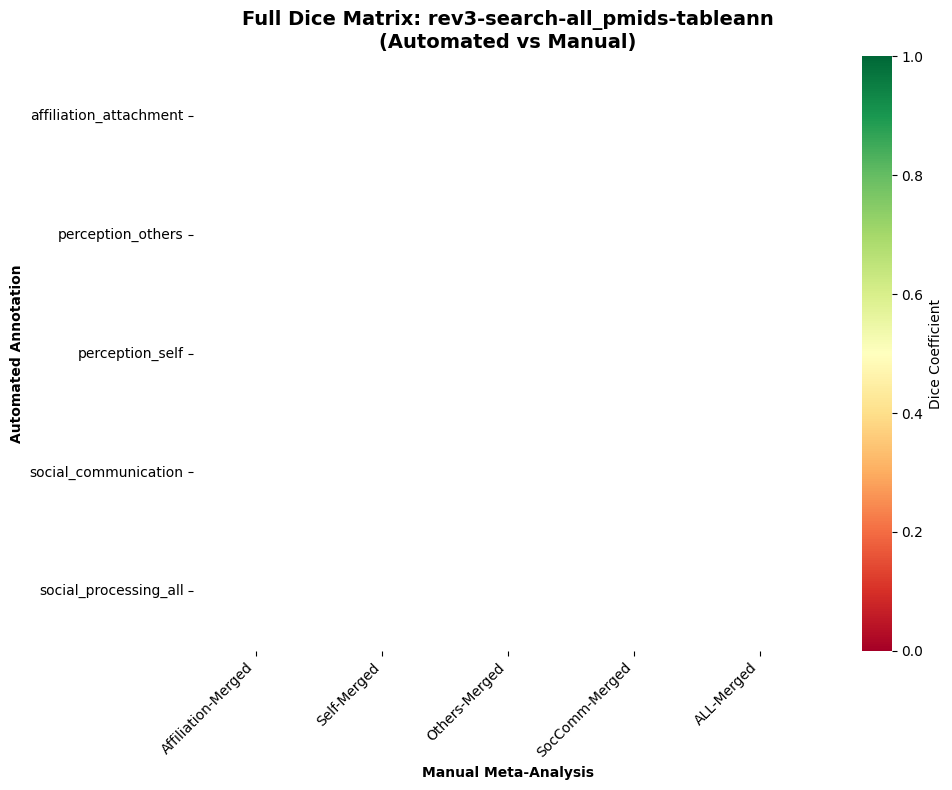


Statistics for rev3-search-all_pmids-tableann:

Run: rev3-search-all_pmids-tableann-ft


,Affiliation-Merged,Self-Merged,Others-Merged,SocComm-Merged,ALL-Merged
affiliation_attachment,NaN,NaN,NaN,NaN,NaN
perception_others,NaN,NaN,NaN,NaN,NaN
perception_self,NaN,NaN,NaN,NaN,NaN
social_communication,NaN,NaN,NaN,NaN,NaN
social_processing_all,NaN,NaN,NaN,NaN,NaN


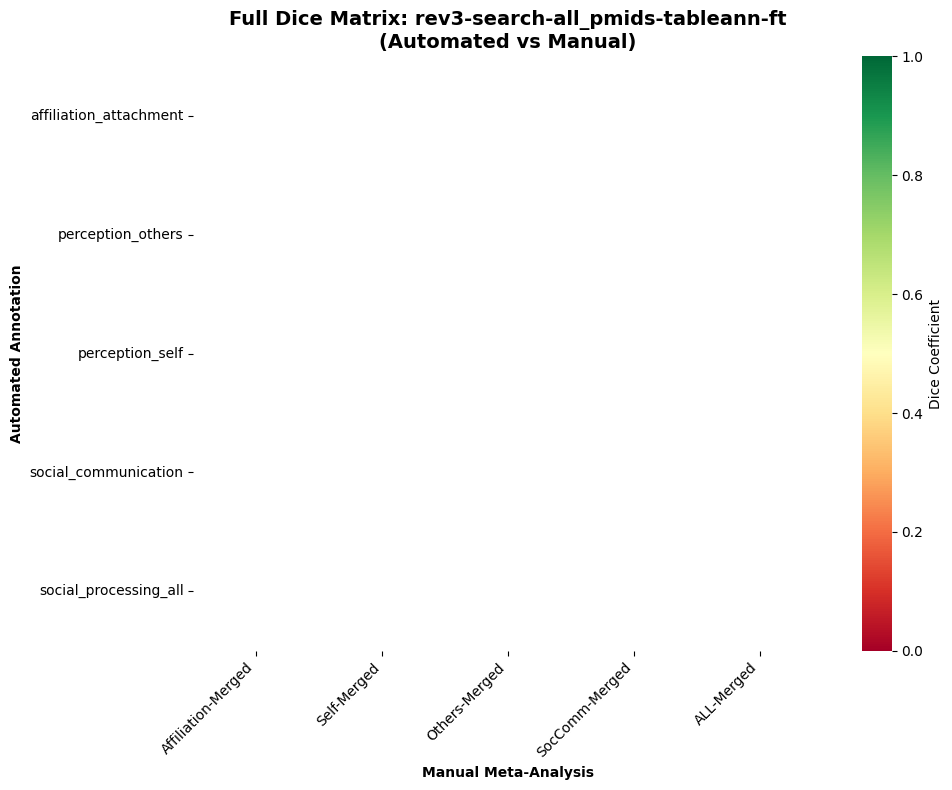


Statistics for rev3-search-all_pmids-tableann-ft:


In [13]:
# Compute FULL Dice matrices (diagonal AND off-diagonal)
# For each run, compute dice(auto_name_i, manual_name_j) for all pairs

print("\nFull Dice Matrices (Auto vs Manual):")
print("="*60)

for run_name, aligned_auto in aligned_auto_by_run.items():
    print(f"\nRun: {run_name}")
    
    # Create full matrix
    # Auto names are the VALUES from mappings (e.g., 'affiliation_attachment')
    auto_names = sorted([auto_name for _, auto_name in mappings.items() if auto_name in aligned_auto])
    # Manual names are the KEYS from mappings (e.g., 'Affiliation-Merged')
    manual_names = [manual_name for manual_name, _ in mappings.items() if manual_name in manual_data_masked]
    
    full_matrix = pd.DataFrame(index=auto_names, columns=manual_names)
    
    for auto_name in auto_names:
        for manual_name in manual_names:
            # aligned_auto is keyed by auto_name
            # manual_data_masked is keyed by manual_name
            if auto_name in aligned_auto and manual_name in manual_data_masked:
                dice_val = compute_dice_coefficient(
                    aligned_auto[auto_name], 
                    manual_data_masked[manual_name], 
                    dice_threshold
                )
                full_matrix.loc[auto_name, manual_name] = dice_val
            else:
                full_matrix.loc[auto_name, manual_name] = np.nan
    
    # Convert to float for display
    full_matrix = full_matrix.astype(float)
    
    display(full_matrix.round(3))
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(full_matrix.astype(float), annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Dice Coefficient'})
    ax.set_title(f'Full Dice Matrix: {run_name}\n(Automated vs Manual)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Manual Meta-Analysis', fontweight='bold')
    ax.set_ylabel('Automated Annotation', fontweight='bold')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'dice_full_matrix_auto_vs_manual_{run_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for {run_name}:")
    flat_values = full_matrix.values.flatten()
    flat_values = flat_values[~np.isnan(flat_values)]
    if len(flat_values) > 0:
        print(f"  Mean Dice: {np.mean(flat_values):.3f}")
        print(f"  Median Dice: {np.median(flat_values):.3f}")
        print(f"  Std Dice: {np.std(flat_values):.3f}")
        
        # Diagonal vs off-diagonal
        diag_vals = []
        off_diag_vals = []
        for i, auto_name in enumerate(auto_names):
            for j, manual_name in enumerate(manual_names):
                val = full_matrix.loc[auto_name, manual_name]
                if not np.isnan(val):
                    # Check if this is a diagonal match
                    if mappings.get(manual_name) == auto_name:
                        diag_vals.append(val)
                    else:
                        off_diag_vals.append(val)
        
        if len(diag_vals) > 0:
            print(f"  Diagonal Mean: {np.mean(diag_vals):.3f} (n={len(diag_vals)})")
        if len(off_diag_vals) > 0:
            print(f"  Off-Diagonal Mean: {np.mean(off_diag_vals):.3f} (n={len(off_diag_vals)})")


In [14]:
diag_table.mean()

rev3-all_pmids                       0.550222
rev3-all_pmids-tableann              0.557177
rev3-all_pmids-tableann-ft           0.588943
rev3-search-all_pmids                0.545939
rev3-search-all_pmids-tableann       0.551244
rev3-search-all_pmids-tableann-ft    0.557589
dtype: float64